In [1]:
import warnings
warnings.filterwarnings("ignore")
# pytorch 相關
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split
from torchvision import models
# 其他
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from copy import copy
import os
import sklearn.metrics as metrics
import seaborn as sns
import pandas as pd
!pip install wandb==0.16.5
import wandb
from wandb.keras import WandbCallback
!pip install git+https://github.com/Po-Hsun-Su/pytorch-ssim.git
import pytorch_ssim
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
!pip install torchsummary
from torchsummary import summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.17.0
    Uninstalling wandb-0.17.0:
      Successfully uninstalled wandb-0.17.0


2024-06-13 11:29:05.937421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 11:29:05.937554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 11:29:06.068105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  Cloning https://github.com/Po-Hsun-Su/pytorch-ssim.git to /tmp/pip-req-build-e5t9mdgw
  Running command git clone --filter=blob:none --quiet https://github.com/Po-Hsun-Su/pytorch-ssim.git /tmp/pip-req-build-e5t9mdgw
  Resolved https://github.com/Po-Hsun-Su/pytorch-ssim.git to commit 3add4532d3f633316cba235da1c69e90f0dfb952
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_ssim: filename=pytorch_ssim-0.1-py3-none-any.whl size=2307 sha256=53674643669f6f57e3c916dfbf4849e2c0c92d7ea962c8e1bcd3b0a19391b734
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9hml2my/wheels/99/53/8e/13474869f278024f6ed5791806bdfe47cfde59f30fe0bc6dd5
Successfully built pytorch_ssim
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-w0qk6xx6
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-w0qk6xx6
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit bd7f877f

In [2]:
# check GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


# 設置超參數

In [3]:
lr = 0.0001
batch_size = 32
epochs = 50

# 數據預處理

In [32]:
# Normalize 和 totensor
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Normalize((0.5, ), (0.5, ))
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Normalize((0.5, ), (0.5, ))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Normalize((0.5, ), (0.5, ))
])

# 切割train_validation & load_data

In [5]:
# 指定 training set 和 validation set 的路徑
input_path = '/kaggle/input/ncku-machine-learning-2024/dataset/train/input'
label_path = '/kaggle/input/ncku-machine-learning-2024/dataset/train/label'

train_image_list = sorted([os.path.join(input_path, f) for f in os.listdir(input_path) if f.endswith('.jpg')])
train_label_list = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.jpg')])

# 切割
from sklearn.model_selection import train_test_split
train_input_path_list , val_input_path_list = train_test_split(train_image_list , test_size = 0.2 , random_state = 42)
train_label_path_list , val_label_path_list = train_test_split(train_label_list , test_size = 0.2 , random_state = 42)

# Dataset

In [34]:
class MLfinal(Dataset):
  def __init__(self, input_list , label_list , transform=None):
    self.input_list = input_list
    self.label_list = label_list
    self.transform = transform

  def __len__(self):
    return len(self.input_list)

  def __getitem__(self, idx):
    image_path = self.input_list[idx]
    label_path = self.label_list[idx]
    
    # 固定 image、label 的大小
    image = Image.open(image_path).resize([224 , 224]).convert('RGB')
    label = Image.open(label_path).resize([224 , 224]).convert('RGB')
    
    image = self.transform(image)
    label = self.transform(label)
    return image, label

train_dataset = MLfinal(train_input_path_list , train_label_path_list , train_transform)
val_dataset = MLfinal(val_input_path_list , val_label_path_list , val_transform)

# Dataloader

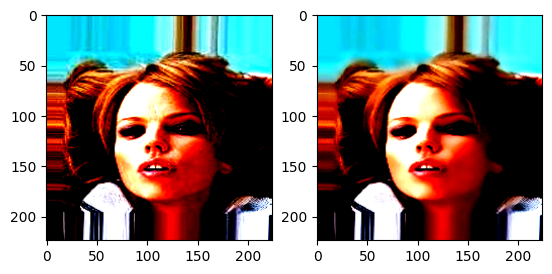

In [35]:
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)

# 檢查 DataLoader 是否成功載入 image 和 ground truth
data_iter = iter(train_loader)
images, labels = next(data_iter)

image, label = images[0], labels[0]

fig , ax = plt.subplots(1 , 2)
ax[0].imshow(image.permute(1, 2, 0))
ax[1].imshow(label.permute(1, 2, 0))
# ax[0].imshow(image.permute(1, 2, 0) , cmap = 'gray')
# ax[1].imshow(label.permute(1, 2, 0) , cmap = 'gray')
plt.show()

# 定義模型

In [67]:
model = smp.Unet('resnet50', in_channels=3, classes=3, activation='sigmoid', encoder_weights='imagenet', decoder_use_batchnorm=True)
model.to(device)
summary(model, (3, 224, 224))

class IOU(nn.Module):
    def __init__(self, size_average=True):
        super(IOU, self).__init__()
        self.size_average = size_average

    def forward(self, pred, target):
        b = pred.shape[0]
        IoU = 0.0
        for i in range(b):
            Iand1 = torch.sum(target[i, :, :, :] * pred[i, :, :, :])
            Ior1 = torch.sum(target[i, :, :, :]) + torch.sum(pred[i, :, :, :]) - Iand1
            IoU1 = Iand1 / Ior1
            IoU += (1 - IoU1)
        return IoU / b if self.size_average else IoU


iou_loss_module = IOU(size_average=True)
bce_loss_module = nn.BCEWithLogitsLoss()
ssim_loss_module = pytorch_ssim.SSIM(window_size=11,size_average=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

architecture = "Unet"

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Wandb

In [68]:
# 紀錄數據
name = architecture + "_" + str(epochs)
wandb.login(key = "bf1bc673d9b5cb8bf02f1937561fb29fcb06a207")
wandb.init(
    # set the wandb project where this run will be logged
    project = "NCKU ML final",
    name = name ,

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": architecture,
    "epochs": epochs,
    "batch_size" : batch_size,
    }
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [69]:
# best model accurancy
train_loss = []
val_loss = []
best_loss = 100000
model_path = "./" + architecture + "_epochs:" + str(epochs) + ".pth"

for epoch in range(epochs):
  # 每個 epoch 前都去看看要不要調 learning rate
  # adjust_learning_rate(optimizer, epoch)
  
  train_epoch_loss = 0.0
  model.train()
  for images, labels in train_loader :
    optimizer.zero_grad()
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    gray = transforms.Compose([
        transforms.Grayscale(num_output_channels=1)
    ])
    outputs = gray(outputs)
    labels = gray(labels)

    # Compute Loss & Update Weight
    loss_iou = iou_loss_module(outputs, labels)
    loss_bce = bce_loss_module(outputs, labels)
    ssim_loss = 1 - ssim_loss_module(outputs,labels)
    batch_loss = loss_iou + loss_bce + ssim_loss
#     batch_loss = ssim_loss
    train_epoch_loss += batch_loss.item()
    #　back propagation
    batch_loss.backward()
    # 更新
    optimizer.step()

    train_epoch_loss += batch_loss.item()

  # Compute Loss
  train_epoch_loss = train_epoch_loss / len(train_loader)
  train_loss.append(train_epoch_loss)

  print('[Epoch:%2d]' % (epoch + 1))
  print('Train Loss : %.3f ' % (train_epoch_loss))
    
  # Validation class correct & class total --------------------------------------------------------------
  model.eval()
  val_epoch_loss = 0.0

  # Validation every epoch
  with torch.no_grad():
    for images, labels in val_loader :
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
        
      gray = transforms.Compose([
        transforms.Grayscale(num_output_channels=1)
      ])
      outputs = gray(outputs)
      labels = gray(labels)

      # Compute Loss & Update Weight
      loss_iou = iou_loss_module(outputs, labels)
      loss_bce = bce_loss_module(outputs, labels)
      ssim_loss = 1 - ssim_loss_module(outputs,labels)
#       batch_loss = ssim_loss
      batch_loss = loss_iou + loss_bce + ssim_loss
      val_epoch_loss += batch_loss.item()
  
  val_epoch_loss = val_epoch_loss / len(val_loader)
  val_loss.append(val_epoch_loss)
  
  wandb.log( {"train_loss" : train_epoch_loss , "epoch" : epoch} )
  wandb.log( {"validation_loss" : val_epoch_loss , "epoch" : epoch} )
  
  print('Validation Loss : %.3f ' % (val_epoch_loss))
  print("----------------------------------------")

  # Save best model
  if val_epoch_loss < best_loss:
    best_loss = val_epoch_loss
    torch.save(model.state_dict() , model_path)

print('Finished Training')
wandb.finish()

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▁▂▃▃▂▁▁███▇▇▇▇▆▆▆▅▅▅▄▆▆▆▅▅▅▄▄▄▃▂▅▅▅▅▅▄▄▄
validation_loss,▄▇▅▅▅▁██▇▇▇▇▇▇▇▇▆▆▆▆▆▇▇▇▆▆▆▆▆▅▅▅▆▆▆▆▆▆▆▆
epoch,49
train_loss,6.36649
validation_loss,3.11082


# test

In [56]:
test_image_root = "/kaggle/input/ncku-machine-learning-2024/dataset/test/input"
train_image_list = sorted([os.path.join(test_image_root, f) for f in os.listdir(test_image_root) if f.endswith('.jpg')])
class MLfinal_t(Dataset):
  def __init__(self, input_list , transform=None):
    self.input_list = input_list
    self.transform = transform

  def __len__(self):
    return len(self.input_list)

  def __getitem__(self, idx):
    image_path = self.input_list[idx]
    
    # 固定 image、label 的大小
    image = Image.open(image_path).resize([224 , 224]).convert('RGB')
    
    image = self.transform(image)
    return image

test_dataset = MLfinal_t(train_image_list , test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# denormalized

In [57]:
# 定義反歸一化的transform
class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# 初始化反歸一化
denormalize = Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def denormalize_and_reshape(tensor):
    tensor = denormalize(tensor)
    tensor = tensor.permute(1, 2, 0)  # 將 (C, H, W) 轉換為 (H, W, C)
    tensor = torch.clamp(tensor, 0, 1)  # 限制像素值範圍在 [0, 1]
    image = Image.fromarray((tensor.numpy() * 255).astype(np.uint8))
    plt.imshow(image)

# def denormalize_and_reshape(tensor):
#     tensor = denormalize(tensor)
#     tensor = tensor.permute(1, 2, 0)  # 將 (C, H, W) 轉換為 (H, W, C)
#     tensor = torch.clamp(tensor, 0, 1)  # 限制像素值範圍在 [0, 1]
#     tensor = tensor * 255
#     array = tensor.numpy()
#     array = np.around(array)
#     array = array.flatten()

# 假設這是模型輸出的張量
# output_tensor = torch.randn(3, 224, 224)  # 這裡用隨機張量代替模型輸出
# denormalize_and_reshape(output_tensor)

In [63]:
model = smp.Unet('resnet50', in_channels=3 , classes=1, activation='sigmoid', encoder_weights='imagenet', decoder_use_batchnorm=True)
model.load_state_dict(torch.load("/kaggle/working/Unet_epochs:50.pth"))
model.cuda()
model.eval()
save_path = "./result"
os.makedirs(save_path, exist_ok=True)

with torch.no_grad():
    for images in test_loader:
      images = images.cuda()
      print(images.size())
      results = model(images)
      print(results.size())
      results = F.interpolate(results, size=(178, 218), mode='bilinear', align_corners=False)
      denormalize_and_reshape(results)

torch.Size([32, 3, 224, 224])
torch.Size([32, 1, 224, 224])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3